Species: ['Z', 'complex_X_2x_Z_', 'X', 'complex_X_Y_2x_Z_', 'Y', 'complex_X_2x_', 'complex_Y_2x_Z_', 'complex_Y_2x_', 'complex_X_2x_Y_Z_']

Original system:
dZ/dt = -Z*complex_X_2x_*kb__ - Z*complex_Y_2x_*kb__ + complex_X_2x_Z_*ku__ + complex_Y_2x_Z_*ku__
dcomplex_X_2x_Z_/dt = -Y*complex_X_2x_Z_*kb__ + Z*complex_X_2x_*kb__ + complex_X_2x_Y_Z_*ku__ - complex_X_2x_Z_*ku__
dX/dt = -2.0*X**2*kb__ - X*complex_Y_2x_Z_*kb__ + 2.0*complex_X_2x_*ku__ + complex_X_Y_2x_Z_*ku__
dcomplex_X_Y_2x_Z_/dt = X*complex_Y_2x_Z_*kb__ - complex_X_Y_2x_Z_*ku__
dY/dt = -2.0*Y**2*kb__ - Y*complex_X_2x_Z_*kb__ + complex_X_2x_Y_Z_*ku__ + 2.0*complex_Y_2x_*ku__
dcomplex_X_2x_/dt = X**2*kb__ - Z*complex_X_2x_*kb__ - complex_X_2x_*ku__ + complex_X_2x_Z_*ku__
dcomplex_Y_2x_Z_/dt = -X*complex_Y_2x_Z_*kb__ + Z*complex_Y_2x_*kb__ + complex_X_Y_2x_Z_*ku__ - complex_Y_2x_Z_*ku__
dcomplex_Y_2x_/dt = Y**2*kb__ - Z*complex_Y_2x_*kb__ - complex_Y_2x_*ku__ + complex_Y_2x_Z_*ku__
dcomplex_X_2x_Y_Z_/dt = Y*complex_X_2x_Z_*kb__ -

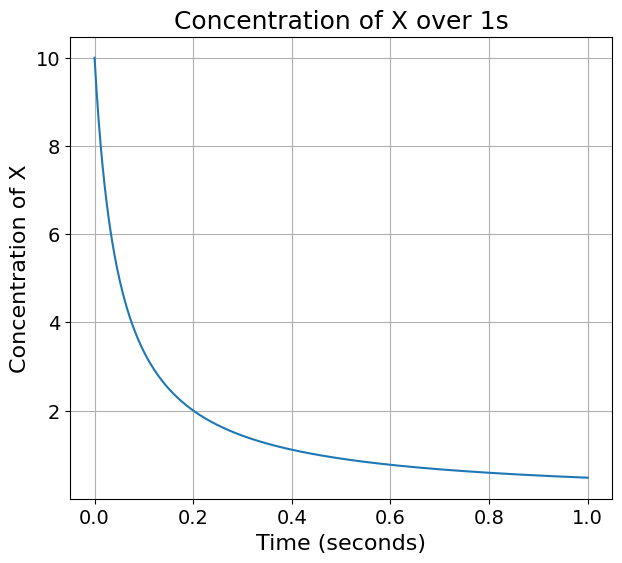

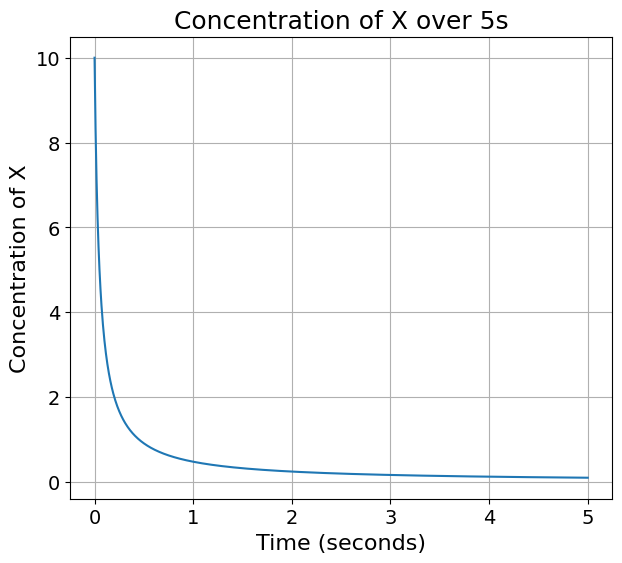

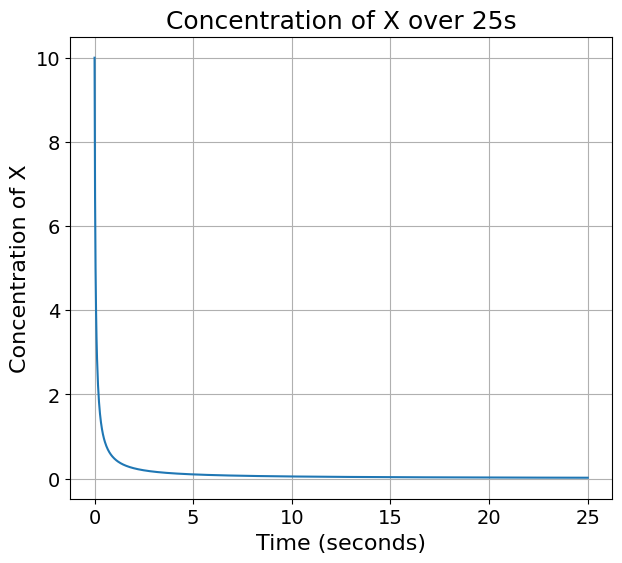

In [97]:
from autoreduce.converters import load_sbml
from sympy import Symbol
import numpy as np

#load CRN
sys = load_sbml("example.xml", outputs = "X")

#set initial concentration of X 
x0_dict = {"X": 10}
for x, x_ic in x0_dict.items():
    curr_ind = sys.x.index(Symbol(x))
    sys.x_init[curr_ind] = x_ic

# list of species
print("Species:", [str(s) for s in sys.x])

# original system of ODEs
print("\nOriginal system:")
for i, eq in enumerate(sys.f):
    print(f"d{sys.x[i]}/dt = {eq}")

from autoreduce.utils import get_ODE
import matplotlib.pyplot as plt 
import numpy as np 

species_names = [str(s) for s in sys.x]

# plot the species over time 
timepoints_ode = np.linspace(0, 1, 1000)
sys_ode = get_ODE(sys, timepoints_ode)  # sys_ode is the object that we get after using the get_ODE function
sol = sys_ode.solve_system().T  

plt.figure(figsize = (7,6))

full_model = np.transpose(np.array(sys.C)@sol)
plt.plot(timepoints_ode, full_model)
plt.title("Concentration of X over 1s",fontsize=18)
plt.xlabel('Time (seconds)',fontsize=16)
plt.ylabel('Concentration of X',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show() 

timepoints2_ode = np.linspace(0,5,1000)
sys_ode = get_ODE(sys, timepoints2_ode)  # sys_ode is the object that we get after using the get_ODE function
sol = sys_ode.solve_system().T  

plt.figure(figsize = (7,6))

full_model = np.transpose(np.array(sys.C)@sol)
plt.plot(timepoints2_ode, full_model)
plt.title("Concentration of X over 5s",fontsize=18)
plt.xlabel('Time (seconds)',fontsize=16)
plt.ylabel('Concentration of X',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show() 

timepoints3_ode = np.linspace(0, 25.0, 1000)
sys_ode = get_ODE(sys, timepoints3_ode)  # sys_ode is the object that we get after using the get_ODE function
sol = sys_ode.solve_system().T  

plt.figure(figsize = (7,6))

full_model = np.transpose(np.array(sys.C)@sol)
plt.plot(timepoints3_ode, full_model)
plt.title("Concentration of X over 25s",fontsize=18)
plt.xlabel('Time (seconds)',fontsize=16)
plt.ylabel('Concentration of X',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show() 




In [98]:
from autoreduce.local_sensitivity import SSM
from numpy.linalg import eigvals, svd
from IPython.display import display, Math
import numpy as np

x0_numeric = [x0_dict.get(str(sym), 0.0) for sym in sys_ode.x]

#SSM object 
ssm_obj = SSM(
    x=sys_ode.x,
    f=sys_ode.f,
    params=sys_ode.params,
    params_values=sys_ode.params_values
)

#compute_J, native function of AutoReduce
J = ssm_obj.compute_J(x0_numeric, mode="accurate")

# display jacobian matrix 
jacobian_str = r"J = \begin{bmatrix}" + r" \\".join(
    [" & ".join([f"{val:.3f}" for val in row]) for row in J]
) + r"\end{bmatrix}"
display(Math(jacobian_str))


#compute eigvals of jacobian 
e_vals = eigvals(J)

#compute SVD of jacobian 
eig_str = r"\lambda = \left[" + ",\ ".join([f"{val:.3f}" for val in e_vals]) + r"\right]"
display(Math(eig_str))

# SVD computation 
U, S, VT = svd(J)

#display SVD
singular_vals_str = r"\Sigma = \left[" + ",\ ".join([f"{s:.3f}" for s in S]) + r"\right]"
display(Math(singular_vals_str))

u_matrix_str = r"U = \begin{bmatrix}" + r" \\".join(
    [" & ".join([f"{val:.3f}" for val in row]) for row in U]
) + r"\end{bmatrix}"
display(Math(u_matrix_str))

vt_matrix_str = r"V^T = \begin{bmatrix}" + r" \\".join(
    [" & ".join([f"{val:.3f}" for val in row]) for row in VT]
) + r"\end{bmatrix}"
display(Math(vt_matrix_str))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Initial concentration: 10.0
Half-life concentration value: 5.0
Half-life time value: 0.050050050050050046

Contract 1 (after half-life):

InVars: [time]
OutVars:[x_output]
A: [
  -time <= -0.05005
]
G: [
  x_output <= 5
  -x_output <= 0
  time <= 1
]


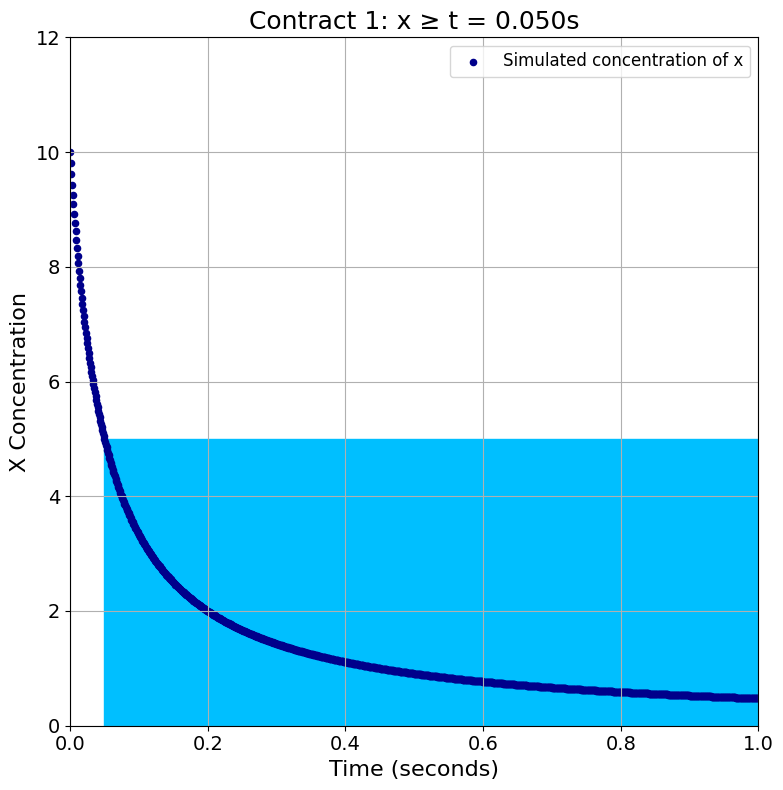


Contract 2 (before half-life):

InVars: [time]
OutVars:[x_output]
A: [
  time <= 0.05005
  -time <= 0
]
G: [
  -x_output <= -5
  x_output <= 10
]


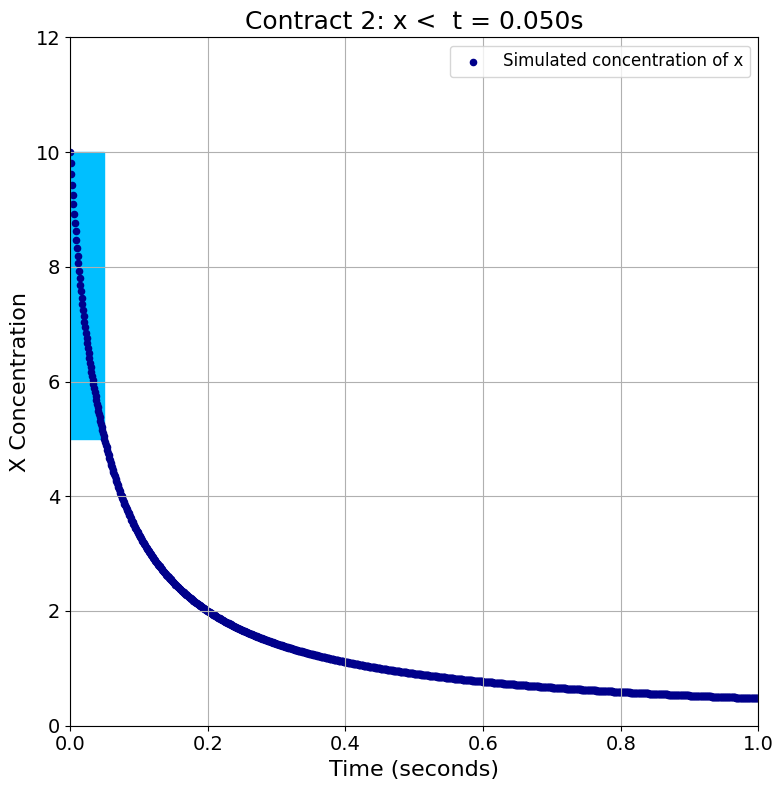

contract1.json saved!
contract2.json saved!


In [84]:
from pacti.contracts import PolyhedralIoContract
from pacti.utils.plots import plot_guarantees
from pacti.iocontract import Var
import matplotlib.pyplot as plt
import numpy as np
import json

#recomputing the system for plotting
timepoints_ode = np.linspace(0, 1, 1000)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T

X_t = np.transpose(np.array(sys.C @ sol))
x_output_data = X_t[:, 0]

#output the half-life of the system automatically, no fuss, no manual programming of the half-life 
initial_x = x_output_data[0]
half_life_x = initial_x / 2
half_life_idx = np.argmin(np.abs(x_output_data - half_life_x))
half_life_time = timepoints_ode[half_life_idx]

min_X = X_t.min()
max_X = X_t.max()

print(f"Initial concentration: {initial_x}")
print(f"Half-life concentration value: {half_life_x}")
print(f"Half-life time value: {half_life_time}\n")

#contract 1: after half life of the system. generates automatically 
contract1 = PolyhedralIoContract.from_dict({
    "assumptions": [
        {"coefficients": {"time": -1}, "constant": -float(half_life_time)}  # time >= half-life
    ],
    "guarantees": [
        {"coefficients": {"x_output": 1}, "constant": float(half_life_x)},   # x <= half-life
        {"coefficients": {"x_output": -1}, "constant": 0},                   # x >= 0
        {"coefficients": {"time": -1}, "constant": 0},                       # time >= 0
        {"coefficients": {"time": 1}, "constant": float(timepoints_ode[-1])}# time <= end
    ],
    "input_vars": ["time"],
    "output_vars": ["x_output"]
})

#contract 2 before half life of the system, generates automatically 
contract2 = PolyhedralIoContract.from_dict({
    "assumptions": [
        {"coefficients": {"time": 1}, "constant": float(half_life_time)},  # time <= half-life
        {"coefficients": {"time": -1}, "constant": 0}                      # time >= 0
    ],
    "guarantees": [
        {"coefficients": {"x_output": -1}, "constant": -float(half_life_x)},  # x >= half-life
        {"coefficients": {"x_output": 1}, "constant": float(max_X)}           # x <= max
    ],
    "input_vars": ["time"],
    "output_vars": ["x_output"]
})


#plotting using plot_guarantees 
print("Contract 1 (after half-life):\n")
print(contract1)

fig = plot_guarantees(
    contract=contract1,
    x_var=Var("time"),
    y_var=Var("x_output"),
    var_values={},
    x_lims=(0, timepoints_ode[-1]),
    y_lims=(0, max_X + 2)
)
fig.set_size_inches(10, 8)

plt.scatter(timepoints_ode, x_output_data, color="darkblue", label="Simulated concentration of x", s=20)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel("X Concentration", fontsize=16)
plt.title(f"Contract 1: x ≥ t = {half_life_time:.3f}s", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nContract 2 (before half-life):\n")
print(contract2)

fig = plot_guarantees(
    contract=contract2,
    x_var=Var("time"),
    y_var=Var("x_output"),
    var_values={},
    x_lims=(0, timepoints_ode[-1]),
    y_lims=(0, max_X + 2)
)
fig.set_size_inches(10, 8)

plt.scatter(timepoints_ode, x_output_data, color="darkblue", label="Simulated concentration of x", s=20)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel("X Concentration", fontsize=16)
plt.title(f"Contract 2: x <  t = {half_life_time:.3f}s", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

#contract dumping 

with open("contract1.json", "w") as f:
    json.dump(contract1.to_machine_dict(), f, indent=4)
print("contract1.json saved!")

with open("contract2.json", "w") as f:
    json.dump(contract2.to_machine_dict(), f, indent=4)
print("contract2.json saved!")
